In [3]:
import json
import numpy as np
from matplotlib import pyplot as plt
from pydantic import BaseModel, StrictBool, StrictInt, StrictStr, StrictFloat, ValidationError

In [4]:
class CameraData(BaseModel):
    hasLeft: StrictBool
    hasRight: StrictBool
    leftDistance: StrictInt
    rightDistance: StrictInt
    regionsCount: StrictInt
    regionsListSize: StrictStr
    unchangedLeft: StrictBool
    unchangedRight: StrictBool

class MotorData(BaseModel):
    leftSpeed: StrictInt
    rightSpeed: StrictInt

class Vec3(BaseModel):
    x: StrictInt
    y: StrictInt
    z: StrictInt

class SensorData(BaseModel):
    accel: Vec3
    gyro: Vec3
    mag: Vec3

class SteerData(BaseModel):
    angle: StrictFloat
    servoPosition: StrictInt

class Data(BaseModel):
    camera: CameraData
    mode: StrictInt
    motor: MotorData
    sensor: SensorData
    steer: SteerData
    timestamp: StrictInt

class Record(BaseModel):
    data: Data
    time: StrictInt

In [5]:
class DataPlotter:
    DATA_FOLDER = '../Data'

    def __init__(self, filename: str) -> None:
        self.data: list[Data]

        with open(f'{self.DATA_FOLDER}/{filename}') as fd:
            data = json.load(fd)
        try:
            self.data = [Record.model_validate(d).data for d in data]
        except ValidationError:
            self.data = [Data.model_validate(d) for d in data]

        self.left_speed = [d.motor.leftSpeed for d in self.data]
        self.right_speed = [d.motor.rightSpeed for d in self.data]
        self.servo_position = [d.steer.servoPosition for d in self.data]
        self.accel_x = [d.sensor.accel.x for d in self.data]
        self.accel_y = [d.sensor.accel.y for d in self.data]
        self.accel_z = [d.sensor.accel.z for d in self.data]
        self.mag_x = [d.sensor.mag.x for d in self.data]
        self.mag_y = [d.sensor.mag.y for d in self.data]
        self.mag_z = [d.sensor.mag.z for d in self.data]
        self.gyro_x = [d.sensor.gyro.x for d in self.data]
        self.gyro_y = [d.sensor.gyro.y for d in self.data]
        self.gyro_z = [d.sensor.gyro.z for d in self.data]
        self.left_distance = [d.camera.leftDistance for d in self.data]
        self.right_distance = [d.camera.rightDistance for d in self.data]

    def __len__(self) -> int:
        return len(self.data)

    def plot_all(self):
        _, axs = plt.subplots(4, 3, figsize=(15, 10))
        axs_flatten = axs.flatten()

        axs_flatten[0].plot(self.left_speed)
        axs_flatten[0].set_title('Left Speed')
        axs_flatten[1].plot(self.right_speed)
        axs_flatten[1].set_title('Right Speed')
        axs_flatten[2].plot(self.servo_position)
        axs_flatten[2].set_title('Servo Position')
        axs_flatten[3].plot(self.accel_x)
        axs_flatten[3].set_title('Accel X')
        axs_flatten[4].plot(self.accel_y)
        axs_flatten[4].set_title('Accel Y')
        axs_flatten[5].plot(self.accel_z)
        axs_flatten[5].set_title('Accel Z')
        axs_flatten[6].plot(self.gyro_x)
        axs_flatten[6].set_title('Gyro X')
        axs_flatten[7].plot(self.gyro_y)
        axs_flatten[7].set_title('Gyro Y')
        axs_flatten[8].plot(self.gyro_z)
        axs_flatten[8].set_title('Gyro Z')
        axs_flatten[9].plot(self.mag_x)
        axs_flatten[9].set_title('Mag X')
        axs_flatten[10].plot(self.mag_y)
        axs_flatten[10].set_title('Mag Y')
        axs_flatten[11].plot(self.mag_z)
        axs_flatten[11].set_title('Mag Z')

        plt.tight_layout()
        plt.show()


In [6]:
auto = DataPlotter('AutoData.json')

In [7]:
test = DataPlotter('test.json')

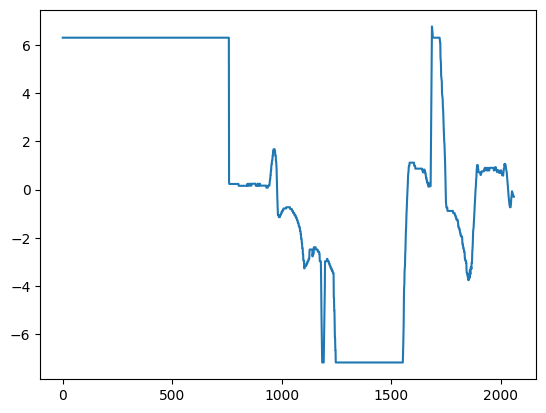

In [15]:
# plt.plot(test.servo_position)
def calculate_distance(left, right):
    leftRatio = left / right
    rightRatio = right / left

    return leftRatio - rightRatio

data = [calculate_distance(data.camera.leftDistance, data.camera.rightDistance) for data in test.data]
plt.plot(data)

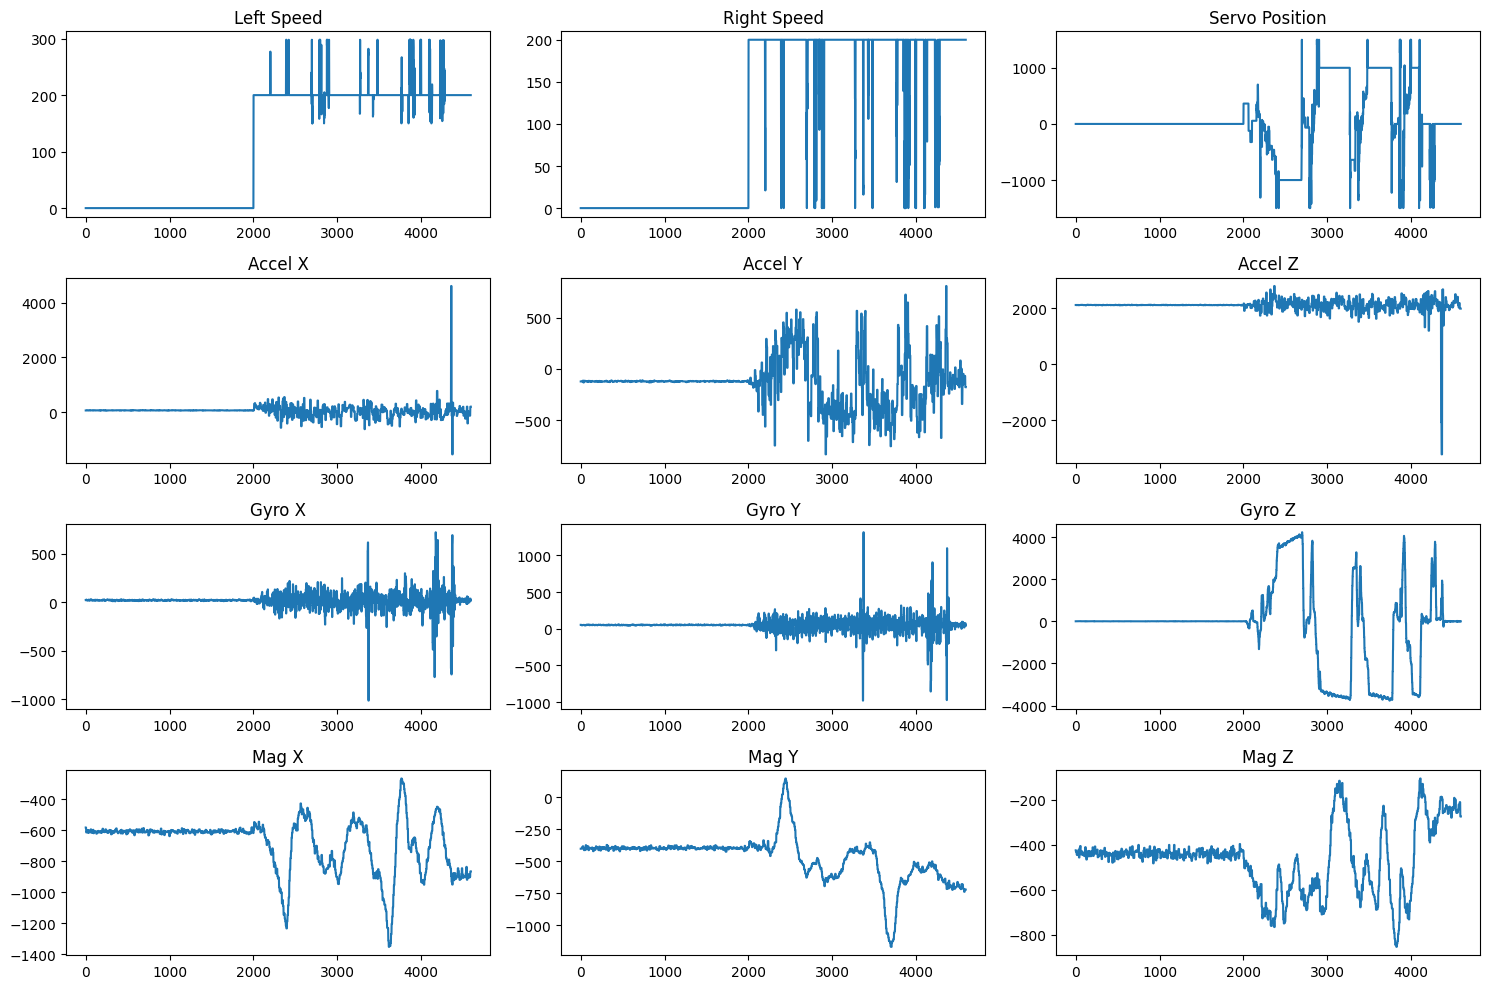

In [68]:
auto.plot_all()

In [69]:
manual_data = DataPlotter('ManualData.json')

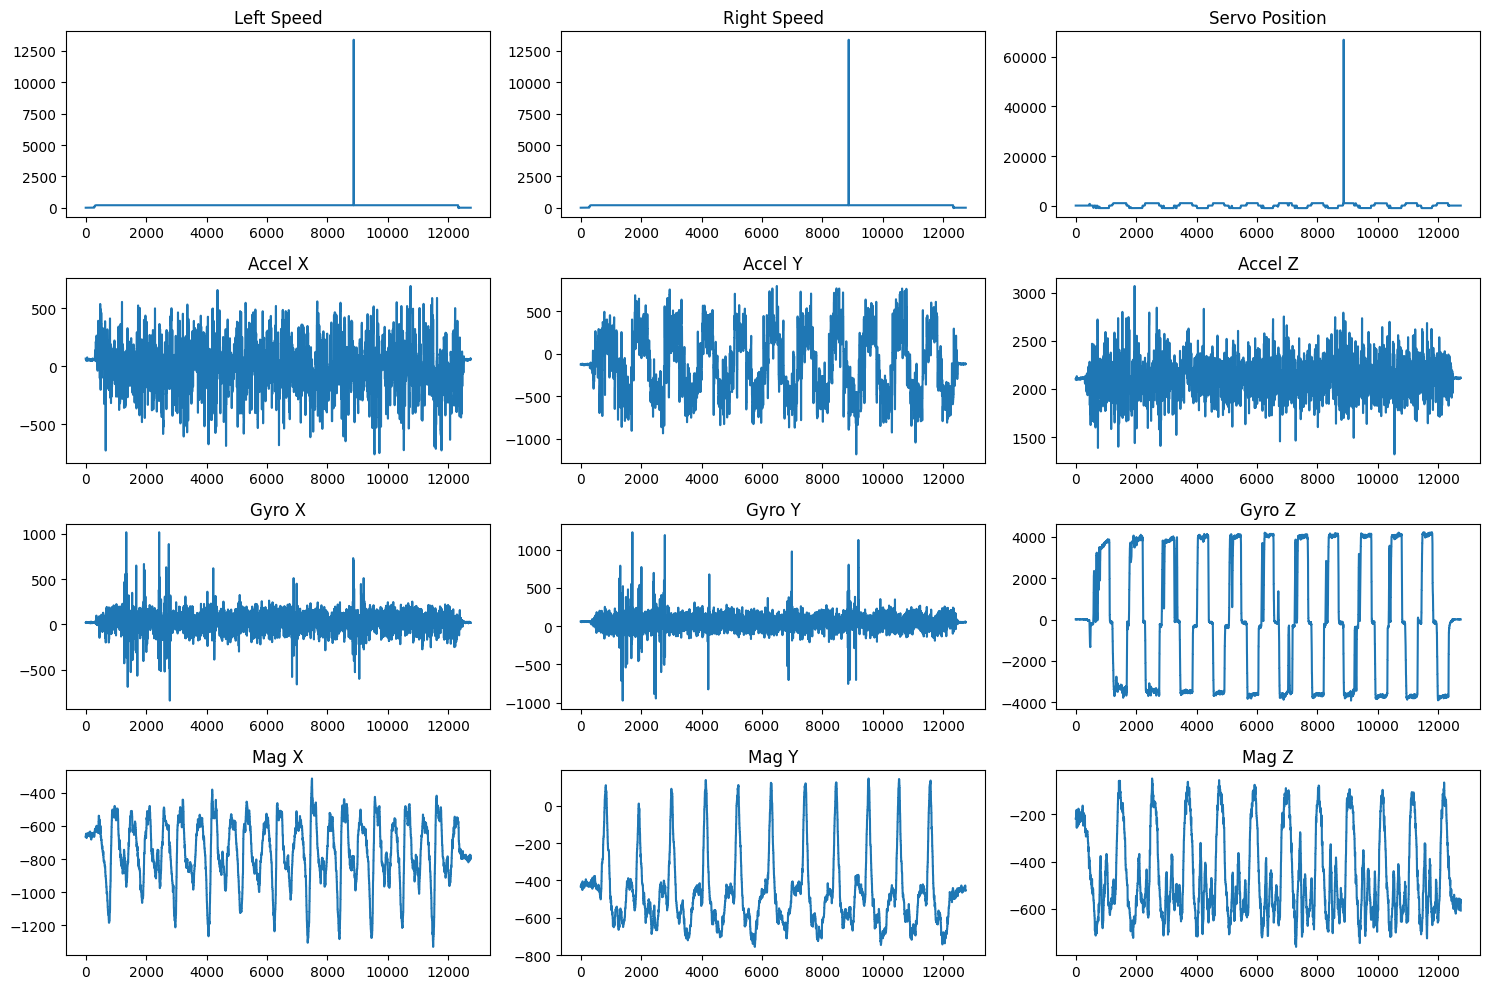

In [70]:
manual_data.plot_all()

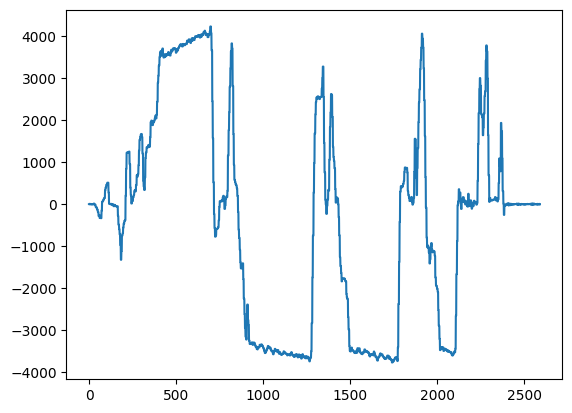

In [71]:
gyro_auto = auto.gyro_z[2000:]
plt.plot(gyro_auto)

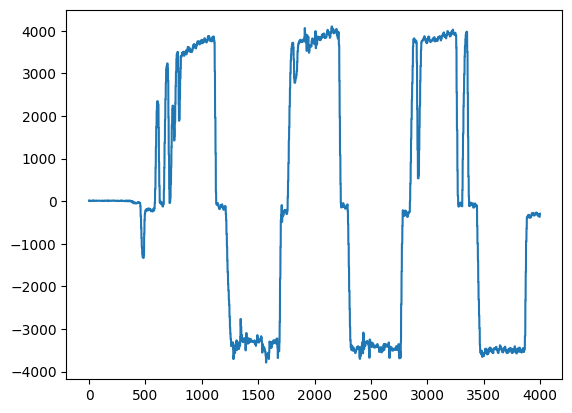

In [72]:
gyro_manual = manual_data.gyro_z[:4000]
plt.plot(gyro_manual)

In [82]:
threshold = 3000
half_lap_detected = False
lap_count = 0
auto_laps = []

data: list[Data] = auto.data
for data_point in data:
    if data_point.sensor.gyro.z >= threshold and not half_lap_detected:
        # Rising edge detected
        auto_laps.append((lap_count, data_point.timestamp))
        half_lap_detected = True
    elif data_point.sensor.gyro.z <= -threshold and half_lap_detected:
        # Falling edge completes one full lap
        lap_count += 1
        half_lap_detected = False

auto_laps

[(0, 12926), (1, 13868), (2, 14430), (3, 14773)]

In [83]:
threshold = 2000
half_lap_detected = False
lap_count = 0
manual_laps = []

data: list[Data] = manual_data.data

for data_point in data:
    if data_point.sensor.gyro.z >= threshold and not half_lap_detected:
        # Rising edge detected
        manual_laps.append((lap_count, data_point.timestamp))
        half_lap_detected = True
    elif data_point.sensor.gyro.z <= -threshold and half_lap_detected:
        # Falling edge completes one full lap
        lap_count += 1
        half_lap_detected = False

manual_laps

[(0, 8629),
 (1, 9807),
 (2, 10892),
 (3, 12053),
 (4, 13117),
 (5, 14188),
 (6, 15289),
 (7, 16309),
 (8, 17396),
 (9, 18402),
 (10, 19483)]

In [84]:
last_lap = auto_laps[0][1]
for i in range(1, len(auto_laps)):
    print(f'Lap {auto_laps[i][0]}: {auto_laps[i][1] - last_lap} ms')
    last_lap = auto_laps[i][1]

Lap 1: 942 ms
Lap 2: 562 ms
Lap 3: 343 ms


In [85]:
last_lap = manual_laps[0][1]
for i in range(1, len(manual_laps)):
    print(f'Lap {manual_laps[i][0]}: {manual_laps[i][1] - last_lap} ms')
    last_lap = manual_laps[i][1]

Lap 1: 1178 ms
Lap 2: 1085 ms
Lap 3: 1161 ms
Lap 4: 1064 ms
Lap 5: 1071 ms
Lap 6: 1101 ms
Lap 7: 1020 ms
Lap 8: 1087 ms
Lap 9: 1006 ms
Lap 10: 1081 ms
